### Testing GPT-4o mini as a pretrained smishing classifier

GPT-4o mini was selected due to its high performance (90%+ of GPT-4o performance), speed, and very low cost ($0.15 per million tokens)

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

### Data preprocessing

Minimal preprocessing is required here - we only need ensure the labels are consistent.

In [ ]:
ds = pd.read_csv("C://Users/Hafna/Downloads/smishing/Dataset_5971.csv")
ds.head(15)

,LABEL,TEXT,URL,EMAIL,PHONE
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...,No,No,No
1,ham,What's up? Do you want me to come online? If y...,No,No,No
2,ham,So u workin overtime nigpun?,No,No,No
3,ham,"Also sir, i sent you an email about how to log...",No,No,No
4,Smishing,Please Stay At Home. To encourage the notion o...,No,No,No
...,...,...,...,...,...
5966,ham,:( but your not here....,No,No,No
5967,ham,Becoz its &lt;#&gt; jan whn al the post ofic...,No,No,No
5968,ham,Its a valentine game. . . send dis msg to all ...,No,No,No
5969,ham,We r outside already.,No,No,No


In [10]:
cols = {'LABEL':'labels'}
ds.rename(columns=cols, inplace=True)
ds

,labels,TEXT,URL,EMAIL,PHONE
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...,No,No,No
1,ham,What's up? Do you want me to come online? If y...,No,No,No
2,ham,So u workin overtime nigpun?,No,No,No
3,ham,"Also sir, i sent you an email about how to log...",No,No,No
4,Smishing,Please Stay At Home. To encourage the notion o...,No,No,No
...,...,...,...,...,...
5966,ham,:( but your not here....,No,No,No
5967,ham,Becoz its &lt;#&gt; jan whn al the post ofic...,No,No,No
5968,ham,Its a valentine game. . . send dis msg to all ...,No,No,No
5969,ham,We r outside already.,No,No,No


In [11]:
ds['labels'] = ds['labels'].str.lower()
ds.labels.unique()

array(['ham', 'smishing', 'spam'], dtype=object)

### OpenAI setup and authentication

In [80]:
%pip install openai

     ---------------------------------------- 0.0/149.4 kB ? eta -:--:--
     -------------------------------------- 149.4/149.4 kB 3.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/389.6 kB ? eta -:--:--
   ---------------------------------------  389.1/389.6 kB 8.1 MB/s eta 0:00:01
   ---------------------------------------- 389.6/389.6 kB 6.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/201.7 kB ? eta -:--:--
   --------------------------------------- 201.7/201.7 kB 12.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/434.9 kB ? eta -:--:--
   -------------------------- ------------- 286.7/434.9 kB 8.9 MB/s eta 0:00:01
   ---------------------------------------- 434.9/434.9 kB 9.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/1.9 MB 10.0 MB/s eta 0:00:01
   ----------------- ---------------------- 0.9/1.9 MB 9.0 MB/s eta 0:00:01
   ---------

The system prompt (which precedes each message in the API call) is defined below:

` You are a model trained to detect smishing, classifying messages as 'ham', 'spam', or 'smishing' based on content. As such, you are only able to respond using one of the words 'ham', 'spam', or 'smishing'. You must classify the following message: `

In [ ]:
import openai

# OpenAI API setup
api_key = "api_key_goes_here"
model = "gpt-4o-mini"
client = openai.OpenAI(api_key=api_key)
system_prompt = """You are a model trained to detect smishing, classifying messages as 'ham', 'spam', or 'smishing' based on content. As such, you are only able to respond using one of the words 'ham', 'spam', or 'smishing'. You must classify the following message:"""

### Batching method
GPT-4o mini supports batching, theoretically improving efficiency. This was ultimately not used, due to the low default batch job priority.

In [108]:
import json

# Prepare the .jsonl file
batch_file_path = 'C://Users/Hafna/Downloads/smishing/batch_input.jsonl'

with open(batch_file_path, 'w') as f:
    for i, text in enumerate(data['TEXT']):
        request = {
            "custom_id": f"request-{i+1}",
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": model,
                "messages": [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": text}
                ],
                "max_tokens": 100
            }
        }
        f.write(json.dumps(request) + '\n')

In [ ]:
# Step 2: Upload the .jsonl file to OpenAI (Batch Input File Upload Step)
with open(batch_file_path, "rb") as f:
    batch_input_file = client.files.create(
        file=f,
        purpose="batch"
    )

TypeError: 'FileObject' object is not subscriptable

In [118]:
print(f"Batch input file uploaded with ID: {batch_input_file.id}")

Batch input file uploaded with ID: file-qkGZxdvfxKGOv52EzPGX3brk


In [119]:
batch_job = client.batches.create(
    input_file_id=batch_input_file.id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
        "description": "Smishing detection batch job"
    }
)
batch_id = batch_job.id
print(f"Batch job created with ID: {batch_id}")

Batch job created with ID: batch_6735119c4e8881908c80689cd8ede0df


In [120]:
import time
batch_id = "batch_6735119c4e8881908c80689cd8ede0df"  # Replace with your actual batch ID

In [121]:
client.batches.retrieve(batch_id)

Batch(id='batch_6735119c4e8881908c80689cd8ede0df', completion_window='24h', created_at=1731531164, endpoint='/v1/chat/completions', input_file_id='file-qkGZxdvfxKGOv52EzPGX3brk', object='batch', status='in_progress', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1731617564, failed_at=None, finalizing_at=None, in_progress_at=1731531166, metadata={'description': 'Smishing detection batch job'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=5971))

In [152]:
batch_status = client.batches.retrieve(batch_id)
status = batch_status.status
if status == "completed":
    print("Batch processing complete!")
    # Retrieve the output file ID
    output_file_id = batch_status["output_file_id"]
    # Download the output file
    file_response = client.files.content(output_file_id)
    output_file_path = 'C://Users/Hafna/Downloads/smishing/batch_output.jsonl'

    # Save the output to a .jsonl file
    with open(output_file_path, 'w') as f:
        f.write(file_response.text)

    print(f"Results saved to {output_file_path}!")
elif status in ["failed", "expired", "cancelled"]:
    print(f"Batch processing failed with status: {status}")
else:
    print(f"Current status: {status}")

Current status: in_progress


### Iterate through and classify the dataset

In [190]:
# Initialize a list to store results
# initialize a dataframe to store the results
results = pd.DataFrame(columns=['TEXT', 'labels', 'class'])
codes_int = {'ham': 0, 'smishing': 1, 'spam': 2}
codes_str = {0: 'ham', 1: 'smishing', 2: 'spam'}
mismatch_count = 0

# Iteratively process each text
for i, text in enumerate(ds['TEXT']):
    n=i+1
    try:
        # Send the API request
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": text}
            ],
            temperature=0.0  # Deterministic output for classification
        )
        
        # Extract the classification result
        classification = response.choices[0].message.content.lower()
        results.loc[n] = [text, ds['labels'][i], codes_int[classification]]
        # check if the classification matches the one in ds
        if not codes_int[classification] == ds['labels'][i]:
            print(f"Mismatch at row {n}: {classification} ({codes_str[ds['labels'][i]]})")
            mismatch_count += 1
            print("Accuracy:", (n - mismatch_count) / n)

        # Print progress
        #print(f"Processed message {n}/{len(data)}: {classification}")
        
        # Optional: delay to avoid rate limits
        time.sleep(0.5)  # Adjust the delay as needed based on rate limits
    except Exception as e:
        print(e)

print("\n\nOverall Accuracy: ", (n - mismatch_count) / n,"("+str(n - mismatch_count)+'/'+str(n)+")")

Mismatch at row 16: spam (ham)
Accuracy: 0.9375
Mismatch at row 25: spam (ham)
Accuracy: 0.92
Mismatch at row 28: smishing (spam)
Accuracy: 0.8928571428571429
Mismatch at row 33: spam (ham)
Accuracy: 0.8787878787878788
Mismatch at row 40: smishing (spam)
Accuracy: 0.875
Mismatch at row 48: smishing (ham)
Accuracy: 0.875
Mismatch at row 59: ham (spam)
Accuracy: 0.8813559322033898
Mismatch at row 63: smishing (ham)
Accuracy: 0.873015873015873
Mismatch at row 87: smishing (spam)
Accuracy: 0.896551724137931
Mismatch at row 90: smishing (spam)
Accuracy: 0.8888888888888888
Mismatch at row 115: ham (spam)
Accuracy: 0.9043478260869565
Mismatch at row 121: smishing (spam)
Accuracy: 0.9008264462809917
Mismatch at row 123: ham (spam)
Accuracy: 0.8943089430894309
Mismatch at row 126: smishing (spam)
Accuracy: 0.8888888888888888
Mismatch at row 141: smishing (spam)
Accuracy: 0.8936170212765957
Mismatch at row 145: spam (ham)
Accuracy: 0.8896551724137931
Mismatch at row 166: smishing (spam)
Accuracy

In [191]:
results.to_csv('C://Users/Hafna/Downloads/smishing/results.csv', index=False)

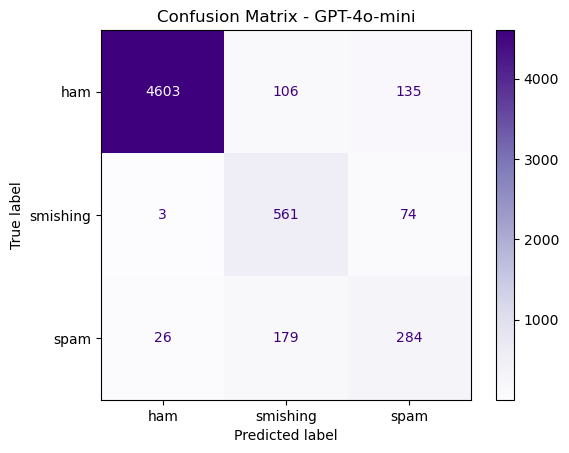

In [201]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(results['labels'], results['class'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'smishing', 'spam'])
disp.plot(cmap='Purples')
plt.title("Confusion Matrix - GPT-4o-mini")
plt.show()

In [202]:
class_report_gpt4 = metrics.classification_report(results['labels'], results['class'],
                                             target_names=['ham', 'smishing', 'spam'])

print(f"Classification Report:\n", class_report_gpt4)

Classification Report:
               precision    recall  f1-score   support

         ham       0.99      0.95      0.97      4844
    smishing       0.66      0.88      0.76       638
        spam       0.58      0.58      0.58       489

    accuracy                           0.91      5971
   macro avg       0.74      0.80      0.77      5971
weighted avg       0.92      0.91      0.92      5971

